# Exploring Metrics for Business Popularity

In [1]:
import json
import pandas as pd
import numpy as np
import math
import datetime

### Reading the data

In [10]:
checkins_df = pd.read_json('./yelp/yelp_academic_dataset_checkin.json', lines=True)

In [11]:
checkins_df.head(2)

,business_id,date
0,--0r8K_AQ4FZfLsX3ZYRDA,2017-09-03 17:13:59
1,--0zrn43LEaB4jUWTQH_Bg,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010..."


In [12]:
business_df = pd.read_json('./yelp/yelp_academic_dataset_business.json', lines=True)

In [13]:
business_df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."


In [14]:
print(f"There are {len(business_df)} businesses and {len(checkins_df)} businesses with check-ins")

There are 160585 businesses and 138876 businesses with check-ins


### Cleaning the data

In [15]:
business_df = business_df.drop(columns=['address', 'postal_code', 'state', 'name'])

In [16]:
business_df = business_df.dropna()

In [17]:
restaurants_df = business_df.loc[business_df["categories"].str.contains("Restaurants")]

In [18]:
print(f"There are {len(restaurants_df)} restaurants in the dataset")

There are 42646 restaurants in the dataset


In [19]:
restaurants_df.head(2)

,business_id,city,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Boulder,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Portland,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."


### Processing the data

#### Frequency of Check-ins for a restaurant, adjusted for time
Date format: YYYY-MM-DD HH:MM:SS

Example: {"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010-12-23 22:55:45, 2011-04-08 17:14:59, 2011-04-11 21:28:45, 2011-04-26 16:42:25, 2011-05-20 19:30:57, 2011-05-24 20:02:21, 2011-08-29 19:01:31"}

In [20]:
def calculate_frequency(row):
    dates = row[1].split(",")
    count = len(dates)
    if count == 0 or count == 1:
        return 0
    
    first_date = datetime.datetime.strptime(dates[0].strip(), "%Y-%m-%d %H:%M:%S")
    last_date = datetime.datetime.strptime(dates[len(dates)-1].strip(), "%Y-%m-%d %H:%M:%S")
    time_period = last_date - first_date
    
    if time_period.days <= 5:
        return 0
    
    return round(count/time_period.days, 2)

In [21]:
checkins_freq_df = checkins_df[['business_id']].copy()
checkins_freq_df['frequency'] = checkins_df.apply(calculate_frequency, axis=1)
checkins_freq_df.head()

,business_id,frequency
0,--0r8K_AQ4FZfLsX3ZYRDA,0.00
1,--0zrn43LEaB4jUWTQH_Bg,0.03
2,--164t1nclzzmca7eDiJMw,0.23
3,--2aF9NhXnNVpDV0KS3xBQ,0.00
4,--2mEJ63SC_8_08_jGgVIg,0.00


In [22]:
restaurants_df = pd.merge(checkins_freq_df, restaurants_df, on='business_id')
restaurants_df.head(3)

,business_id,frequency,city,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,--164t1nclzzmca7eDiJMw,0.23,Austin,30.264896,-97.731028,4.0,137,0,"{'Alcohol': 'u'full_bar'', 'BusinessAcceptsCre...","Food, Ethnic Food, Nightlife, Restaurants, Div...","{'Monday': '18:0-0:0', 'Tuesday': '11:30-0:0',..."
1,--6COJIAjkQwSUZci_4PJQ,0.10,Portland,45.467868,-122.714524,4.0,99,0,"{'BusinessParking': '{'garage': False, 'street...","Breakfast & Brunch, Bakeries, Tea Rooms, Coffe...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."
2,--UNNdnHRhsyFUbDgumdtQ,0.60,Portland,45.522796,-122.657872,4.5,1236,1,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","French, Restaurants, American (New)","{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ..."


In [23]:
len(restaurants_df)

42089

#### Closed Restaurants

In [16]:
closed_restaurants_df = restaurants_df[restaurants_df["is_open"] == 0]

#### Rounding Up the Star Ratings

In [17]:
restaurants_df["rounded_stars"] = restaurants_df["stars"].apply(lambda x: math.ceil(x))

### Analyzing the data

#### How many restaurants are still open?

In [18]:
closed = len(closed_restaurants_df)
still_open = len(restaurants_df) - closed
print(f"{still_open} restaurants are still open, while {closed} ({round(closed/len(restaurants_df)*100, 2)}%) are closed.")

28428 restaurants are still open, while 13661 (32.46%) are closed.


#### How are the star ratings distributed for restaurants?

In [9]:
restaurants_df['stars'].value_counts()

4.0    11835
3.5    10763
3.0     6606
4.5     6309
2.5     3310
2.0     1839
5.0     1159
1.5      709
1.0      116
Name: stars, dtype: int64

In [10]:
star_avg = sum(restaurants_df['stars'])/len(restaurants_df['stars'])
print(f"Average star rating is {round(star_avg, 2)} for all restaurants")

Average star rating is 3.57 for all restaurants


#### Is there a correlation between frequency and review count?

In [21]:
restaurants_df[['review_count', 'frequency']].corr()

,review_count,frequency
review_count,1.000000,0.759045
frequency,0.759045,1.000000


#### Is there a correlation between frequency and star rating?

In [22]:
restaurants_df[['frequency', 'stars']].corr()

,frequency,stars
frequency,1.000000,0.173341
stars,0.173341,1.000000


In [23]:
restaurants_df[['frequency', 'rounded_stars']].corr()

,frequency,rounded_stars
frequency,1.000000,0.158649
rounded_stars,0.158649,1.000000


#### Is there a correlation between star rating and review count?

In [11]:
restaurants_df[['review_count', 'stars']].corr()

,review_count,stars
review_count,1.000000,0.143764
stars,0.143764,1.000000


In [25]:
restaurants_df[['review_count', 'rounded_stars']].corr()

,review_count,rounded_stars
review_count,1.000000,0.133541
rounded_stars,0.133541,1.000000


#### Plotting the star ratings and frequency

<AxesSubplot:xlabel='frequency'>

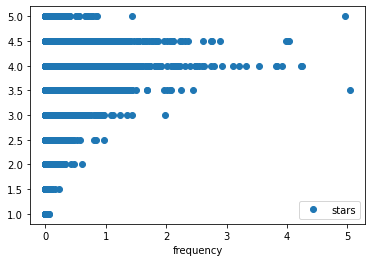

In [24]:
restaurants_df.plot(x='frequency', y='stars', style='o')

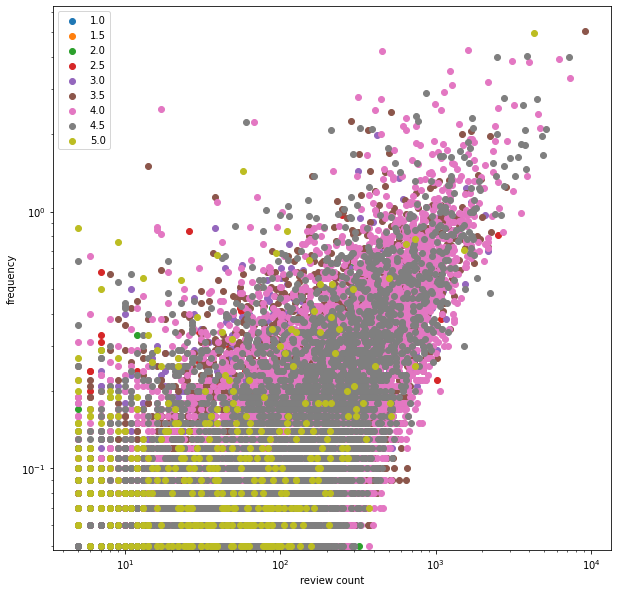

In [65]:
import matplotlib.pyplot as plt

scatter_x = restaurants_df["review_count"].values
scatter_y = restaurants_df["frequency"].values
group = restaurants_df["stars"].values
# cdict = {1: 'red', 2: 'blue', 3: 'green'}

fig, ax = plt.subplots(figsize=(10,10))
fig.patch.set_facecolor("white")
ax.set_yscale('log')
ax.set_xscale('log')
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], label = g)
ax.legend()
plt.xlabel("review count")
plt.ylabel("frequency")
plt.show()
fig.savefig("scatter.png", transparent=False)

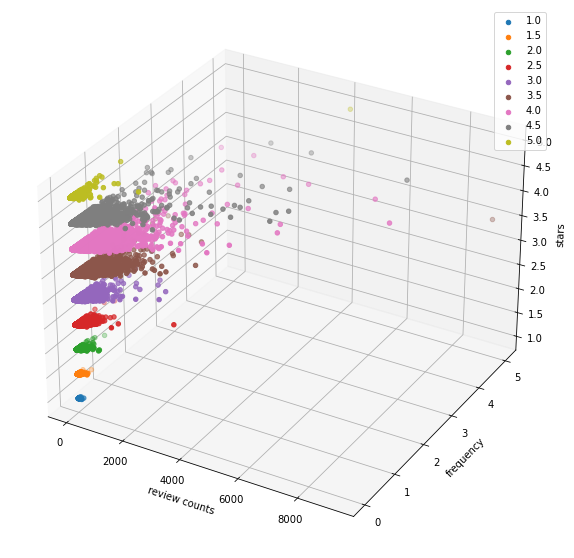

In [52]:
rev = restaurants_df["review_count"].values
freq = restaurants_df["frequency"].values
star = restaurants_df["stars"].values
# cdict = {1: 'red', 2: 'blue', 3: 'green'}

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

# ax.scatter3D(rev, freq, star)

for g in np.unique(star):
    ix = np.where(star == g)
    ax.scatter3D(rev[ix], freq[ix], star[ix], label = g)
ax.legend()
ax.set_xlabel('review counts')
ax.set_ylabel('frequency')
ax.set_zlabel('stars')
plt.show()
fig.savefig("scatter3D.png", transparent=False)

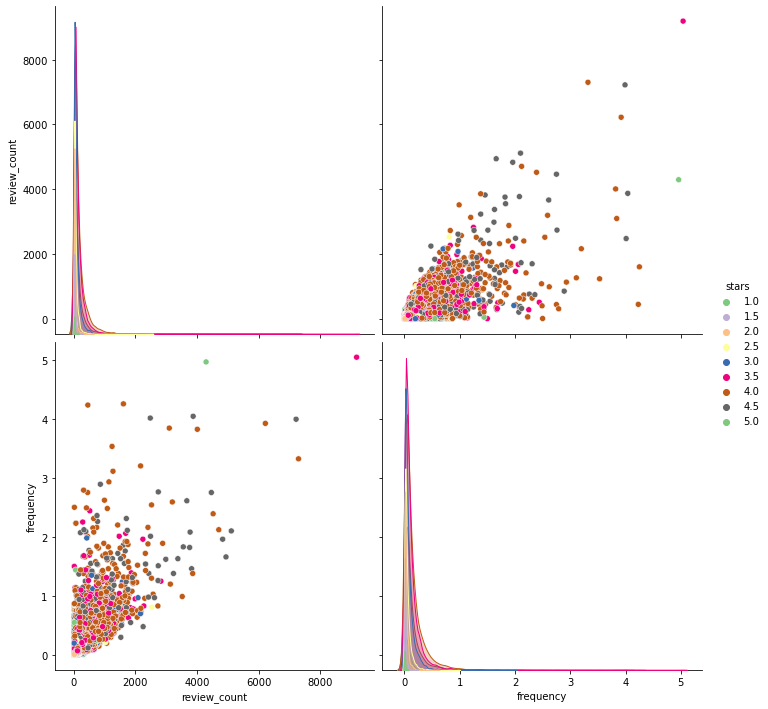

In [64]:
import seaborn
sns_plot = seaborn.pairplot(restaurants_df[["review_count", "frequency", "stars"]], hue="stars", height=5, palette="Accent", ax=ax)
sns_plot.savefig("pairplot.png")

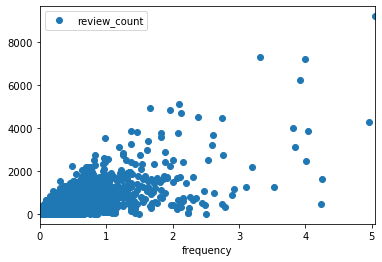

In [28]:
restaurants_df.plot(x='frequency', y='review_count', style='o')

#### Average Frequency for each Star Rating

In [29]:
restaurants_df.groupby("stars")["frequency"].mean()

stars
1.0    0.009151
1.5    0.016802
2.0    0.030122
2.5    0.050260
3.0    0.076656
3.5    0.114924
4.0    0.154327
4.5    0.137322
5.0    0.063868
Name: frequency, dtype: float64

In [30]:
avg_freq_stars = restaurants_df.groupby("rounded_stars")["frequency"].mean()

In [31]:
avg_freq_stars

rounded_stars
1    0.009151
2    0.026439
3    0.067831
4    0.135562
5    0.126380
Name: frequency, dtype: float64

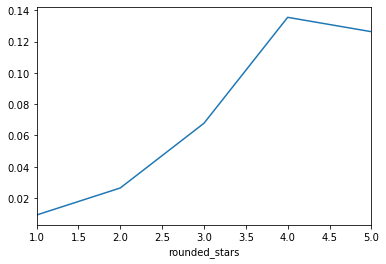

In [32]:
avg_freq_stars.plot()

In [34]:
restaurants_df.groupby("rounded_stars")["frequency"].std()

rounded_stars
1    0.012658
2    0.036041
3    0.092747
4    0.205498
5    0.230430
Name: frequency, dtype: float64

#### Average Count Review for each Star Rating

In [ ]:
avg_freq_reviews = restaurants_df.groupby("rounded_stars")["review_count"].mean()

In [ ]:
avg_freq_reviews

In [ ]:
avg_freq_reviews.plot()